In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.spatial.distance import pdist
from sklearn.metrics import pairwise_distances
from scipy.sparse import *
import networkx as nx
import community as community_louvain
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics.cluster import v_measure_score
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from sklearn.neighbors import kneighbors_graph
from sklearn import metrics
from scipy import sparse
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import NMF
from sklearn.preprocessing import MinMaxScaler
from numpy import linalg as LA
import numpy.matlib
import glob
import cv2
from matplotlib import rcParams
import random

from sklearn.metrics import davies_bouldin_score

from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics.cluster import adjusted_mutual_info_score
from sklearn.metrics.cluster import completeness_score

from scipy.ndimage import gaussian_filter

from sklearn import random_projection
import collections

In [33]:
from scipy.ndimage import gaussian_filter
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization

In [3]:
# data_path_root = 'https://raw.githubusercontent.com/marcosd3souza/FSMethodology/master/train_datasets/'
# data_path = data_path_root + 'nci9_dataset.csv'

def read_data(name, data_sep=' ', has_labels=True):
    data_path =  f'/media/marcos/DATA/datasets/preprocessed/{name}.csv'

    data = pd.read_csv(data_path, data_sep)
#     data = data.sample(frac = 1)
    
    X = data
    y = []
    if has_labels:
        y = data['Y']
        X = data.drop(['Y'], axis=1)
        print(len(np.unique(y)))
        
    print(X.shape)
    
    return X, y

# dataset_name = 'pixraw10P'
# X, y = read_data(dataset_name)

In [4]:
def encoder_data(X, enconder_size=100):
    n_inputs = X.shape[1]
    # define encoder
    visible = Input(shape=(n_inputs,))
    # encoder level 1
    e = Dense(n_inputs*2)(visible)
    e = BatchNormalization()(e)
    e = LeakyReLU()(e)
    # encoder level 2
    e = Dense(n_inputs)(e)
    e = BatchNormalization()(e)
    e = LeakyReLU()(e)
    # bottleneck
    n_bottleneck = enconder_size
    bottleneck = Dense(n_bottleneck)(e)
    encoder = Model(inputs=visible, outputs=bottleneck)
    X_encoded = encoder.predict(X)
    
    return X_encoded

In [13]:
def show_labeled_images (clustering, images_filenames):
    labels = np.unique(clustering)
    
    for label in labels:
        print('cluster: ', label)
        images_index = np.where(clustering == label)[0]
        
        label_paths = np.array(images_filenames)[images_index]
        objs = [p.split('/')[-1].split('__')[0] for p in label_paths]

        print('counter: ', collections.Counter(objs))
        
        images_index = images_index[0:20]

        %matplotlib inline

        rcParams['figure.figsize'] = 25 ,25

        images_to_show = []

        for file_index in images_index:
            images_to_show.append(images_filenames[file_index])

        fig, ax = plt.subplots(1,len(images_to_show))

        i = 0
        for img_path in images_to_show:
            # img = mpimg.imread(img_path)
            img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2GRAY)
            ax[i].imshow(img, cmap="gray")
            i = i + 1
        plt.show()

In [4]:
def do_laplace_score(X, W):
    D = np.array(W.sum(axis=1))
    L = W
    tmp = np.dot(np.transpose(D), X)
    D = diags(np.transpose(D), [0])
    Xt = np.transpose(X)
    t1 = np.transpose(np.dot(Xt, D.todense()))
    t2 = np.transpose(np.dot(Xt, L.todense()))
    # compute the numerator of Lr
    D_prime = np.sum(np.multiply(t1, X), 0) - np.multiply(tmp, tmp)/D.sum()
    # compute the denominator of Lr
    L_prime = np.sum(np.multiply(t2, X), 0) - np.multiply(tmp, tmp)/D.sum()
    # avoid the denominator of Lr to be 0
    D_prime[D_prime < 1e-12] = 10000

    # compute laplacian score for all features
    score = 1 - np.array(np.multiply(L_prime, 1/D_prime))[0, :]
    return np.transpose(score)

def construct_S(X, k=5, metric='cosine'):
    D = pairwise_distances(X, metric=metric)
    D **= 2
    np.fill_diagonal(D, 1)
#     D = pairwise_distances(X, metric=lambda a, b : mean_squared_error(a, b))
    n_samples = X.shape[0]
    # sort the distance matrix D in ascending order
#     dump = np.sort(D, axis=1)
    idx = np.argsort(D, axis=1)
    # choose the k-nearest neighbors for each instance
    idx_new = idx[:, 0:k+1]
#     dump_new = dump[:, 0:k+1]
    # compute the pairwise heat kernel distances
#     dump_heat_kernel = np.exp(-dump_new/2)
    G = np.zeros((n_samples*(k+1), 3))
    G[:, 0] = np.tile(np.arange(n_samples), (k+1, 1)).reshape(-1)
    G[:, 1] = np.ravel(idx_new, order='F')
    G[:, 2] = 1
#     G[:, 2] = np.ravel(dump_heat_kernel, order='F')
    # build the sparse affinity matrix W
    W = csc_matrix((G[:, 2], (G[:, 0], G[:, 1])), shape=(n_samples, n_samples))
    bigger = np.transpose(W) > W
    W = W - W.multiply(bigger) + np.transpose(W).multiply(bigger)
    
    return W

In [9]:
def construct_spectral_info(W):
    n_samples = W.shape[0]
    # build the degree matrix
    X_sum = np.array(W.sum(axis=1))
    D = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
        D[i, i] = X_sum[i]

    # build the laplacian matrix
    L = D - W
    d1 = np.power(np.array(W.sum(axis=1)), -0.5)
    d1[np.isinf(d1)] = 0
    d2 = np.power(np.array(W.sum(axis=1)), 0.5)
    v = np.dot(np.diag(d2[:, 0]), np.ones(n_samples))
    v = v/LA.norm(v)

    # build the normalized laplacian matrix
    L_hat = (np.matlib.repmat(d1, 1, n_samples)) * np.array(L) * np.matlib.repmat(np.transpose(d1), n_samples, 1)

    # calculate and construct spectral information
    vals, vecs = np.linalg.eig(L_hat)
    vals = np.flipud(vals)
    vecs = np.fliplr(vecs)
    
    return vals, vecs

In [5]:
def evaluate(clustering, y):
    
    acc = accuracy_score(y, clustering)
    cr = adjusted_rand_score(y, clustering)
    comp = completeness_score(y, clustering)
    nmi = v_measure_score(y, clustering)
#     ami = adjusted_mutual_info_score(y, clustering)
    
#     b_acc = balanced_accuracy_score(y, clustering)

#     print('acc: ', acc)
#     print('balanced acc: ', b_acc)
    print('completeness: ', comp)
    print('cr: ', cr)
    print('nmi: ', nmi)
#     print('ami: ', ami)

In [6]:
def get_clustering(S, X):
    G = nx.from_numpy_array(S)
    partition = community_louvain.best_partition(G, resolution=1.0, randomize=False)

    clustering = []
    for key, value in partition.items():
    #     v.setdefault(key, set()).add(value)
        clustering.append(value)

    # G = nx.adjacency_matrix(best_S)
    # G = nx.from_numpy_matrix(S_arry)
    print('n_clusters: ', len(np.unique(clustering)))
    
    avg_sil = metrics.silhouette_score(X, clustering, metric='cosine')
#     db = davies_bouldin_score(X, clustering)
    
    print('sil: ', avg_sil)
#     print('davies_bouldin: ', db)
    
#     nx.draw(G, with_labels=True, font_weight='bold')
#     plt.show()
    
    return clustering

In [198]:
X, y = read_data('ALLAML', data_sep=' ')

/home/marcos/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  """Entry point for launching an IPython kernel.


2
(72, 7129)


In [193]:
data_path =  f'/media/marcos/DATA/datasets/preprocessed/COIL20.mat'

from scipy.io import loadmat
annots = loadmat(data_path)
X = pd.DataFrame(annots['X'])
y = pd.DataFrame(annots['Y']).values.ravel()

# data = pd.read_csv(data_path, ' ')
# data.descibe()
X.shape

(1440, 1024)

In [210]:
%%time

def get_S(data):
    n_neighbors = 5
    model = NMF(n_components=30, init='random', random_state=0, max_iter=5000)    
    
    S = construct_S(data, n_neighbors)
    model.fit_transform(S)

    old_loss = model.reconstruction_err_
    print('init loss: ', old_loss)

    T = 30
    best_loss = 999999999999999
    old_loss = 999999999999999
    best_S = S
    best_X = None
    tol = 0.0001
    
    loss_rate = []

    for t in range(T):
        # a decomposição comprime os dados de entrada
        # logo as características mais relevantes (vizinhança forte)
        # tende a persistir nos dados comprimidos
        # e os detalhes menos relevantes da matriz de similaridade
        # tendem a desaparecer
        
        W = model.fit_transform(S)
        H = model.components_
        loss = model.reconstruction_err_

        loss_rate.append(loss)
        if (loss > old_loss) or abs(old_loss - loss) <= tol:
            break

        if loss < best_loss:
            best_loss = loss
            best_S = construct_S(W.dot(H), n_neighbors)
            
            vals, vecs = construct_spectral_info(best_S)
            idx = np.argsort(vals.real)
            best_X = vecs[:, idx[0:20]].real

        old_loss = loss
        
        S = gaussian_filter(W.dot(H), sigma=2)

    print('best loss: ', best_loss)
    print('n iter: ', t)
    
    return best_S, best_X


# X_new = _reduce(X)

S, X_new = get_S(X)
S = S.toarray()

# plt.plot(range(0, len(loss_rate)), loss_rate)
# S = construct_S(X_new, n_neighbors).toarray()

clustering = get_clustering(S, X_new)

init loss:  105.65620500870814
best loss:  0.0407508084485854
n iter:  5
n_clusters:  27
sil:  0.78349784833602
CPU times: user 1min 18s, sys: 700 ms, total: 1min 19s
Wall time: 19.8 s


completeness:  0.3216417813881774
cr:  0.25119071814734595
nmi:  0.47108976962976845


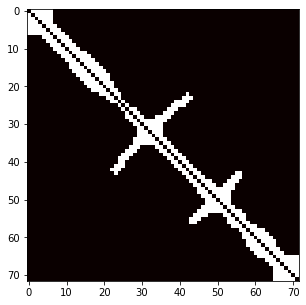

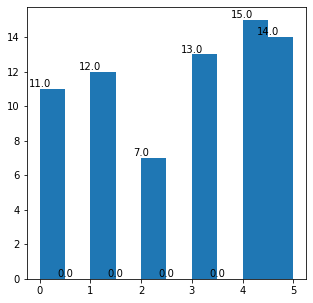

In [204]:
evaluate(clustering, y)

rcParams['figure.figsize'] = 5,5
_ = plt.imshow(S, cmap='hot', interpolation='nearest')
plt.show()

# G = nx.from_numpy_array(S)
# nx.draw(G, with_labels=True, font_weight='bold')
# plt.show()

s, n, _ = plt.hist(clustering)
for i in range(len(s)):
    plt.annotate(s[i], xy=(n[i],s[i]), ha='center', va='bottom')
    
plt.show()

In [16]:
clustering = np.array([[i+1] * 72 for i in range(20)]).ravel()

In [ ]:
img_path_root = '/media/marcos/DATA/datasets/preprocessed/coil-20/'
image_paths = np.array([[f'{img_path_root}obj{i}__{j}.png' for j in range(72)] for i in range(1, 21)]).ravel()

image_paths = list(image_paths)

show_labeled_images(clustering, image_paths)

# Experiments on Datasets (medium complexity)

###########################################################################################
dataset:  warpAR10P
10
(130, 2400)
init loss:  19.403578683764344


/home/marcos/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only


best loss:  0.011089822565863118
n iter:  4


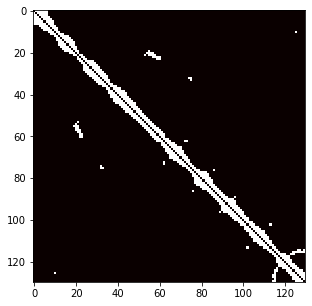

n_clusters:  10
sil:  0.4155376217227588
completeness:  0.7826828630577944
cr:  0.6123865110246434
nmi:  0.7802539965622358
###########################################################################################
dataset:  warpPIE10P
10
(210, 2420)
init loss:  23.906126445744825


/home/marcos/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only


best loss:  0.03468002843207904
n iter:  2


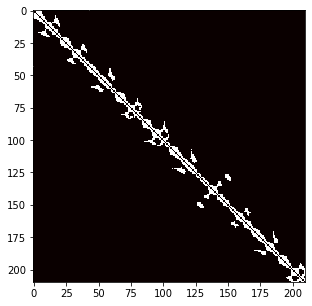

n_clusters:  10
sil:  0.4904963312834992
completeness:  0.9572494429482967
cr:  0.9236394030089788
nmi:  0.9556860121378389
###########################################################################################
dataset:  pixraw10P


/home/marcos/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only


10
(100, 10000)
init loss:  10.404306468181673
best loss:  0.0054372771623379945
n iter:  16


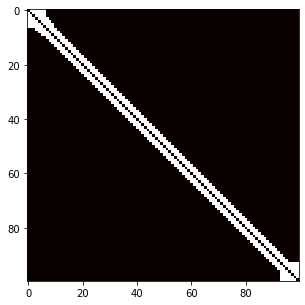

n_clusters:  8
sil:  0.28844435288124803
completeness:  0.8400235362281061
cr:  0.6097015650821425
nmi:  0.7942520280373276
###########################################################################################
dataset:  orlraws10P


/home/marcos/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only


10
(100, 10304)
init loss:  11.10769187853964
best loss:  0.0073688970386938755
n iter:  13


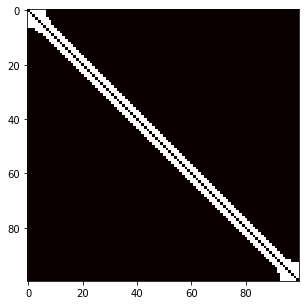

n_clusters:  8
sil:  0.29802153478875737
completeness:  0.7959955250946253
cr:  0.5230097732232659
nmi:  0.7487856395556219
###########################################################################################
dataset:  nci9


/home/marcos/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only


9
(60, 9712)
init loss:  7.988372851987027
best loss:  0.005346880647381366
n iter:  5


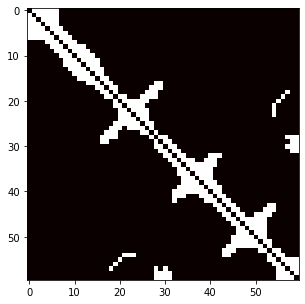

n_clusters:  6
sil:  0.2451147172387632
completeness:  0.7496534726158897
cr:  0.48044235101372107
nmi:  0.6785387996044504
###########################################################################################
dataset:  Carcinom


/home/marcos/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only


11
(174, 9182)
init loss:  23.649050437266062
best loss:  0.011396570173898916
n iter:  8


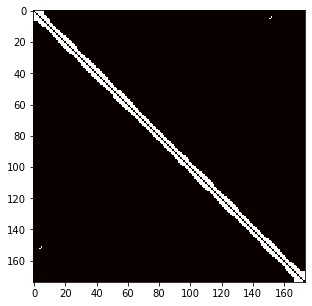

n_clusters:  11
sil:  0.43337440441923447
completeness:  0.5925847870038543
cr:  0.36161687479971716
nmi:  0.6054696397913022
###########################################################################################
dataset:  TOX171


/home/marcos/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only


4
(171, 5748)
init loss:  24.624381516553647
best loss:  0.01073063177607514
n iter:  7


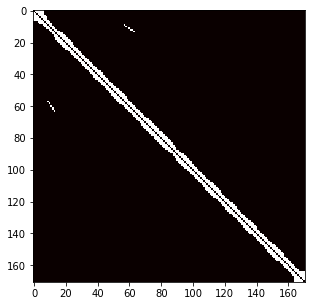

n_clusters:  9
sil:  0.35573011052128706
completeness:  0.608818641137468
cr:  0.5265078525804548
nmi:  0.7432944910593204
###########################################################################################
dataset:  ALLAML


/home/marcos/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only


2
(72, 7129)
init loss:  10.413653520328529
best loss:  0.005873756507700837
n iter:  4


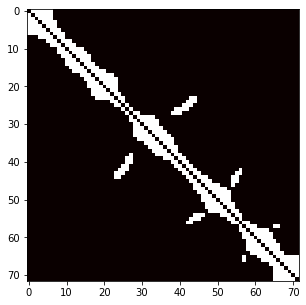

n_clusters:  6
sil:  0.25216540084682393
completeness:  0.26836317002650484
cr:  0.22182874984821133
nmi:  0.392557579347823
###########################################################################################
dataset:  ProstateGE


/home/marcos/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only


2
(102, 5966)
init loss:  14.682901535616734
best loss:  0.009531568199659434
n iter:  4


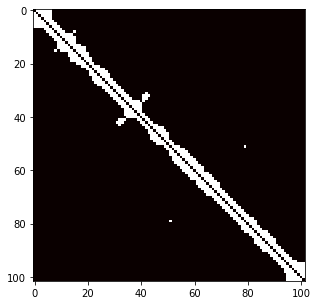

n_clusters:  9
sil:  0.3641798757376595
completeness:  0.30903955184522014
cr:  0.22709939401910326
nmi:  0.4672487101878543
###########################################################################################
dataset:  isolet
26
(1560, 617)


/home/marcos/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only


init loss:  105.65620500870814
best loss:  0.0407508084485854
n iter:  5


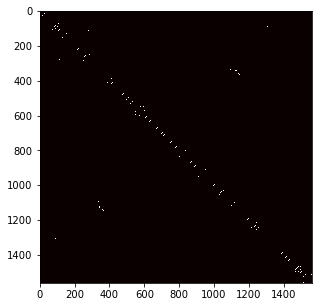

n_clusters:  27
sil:  0.78349784833602
completeness:  0.8996761420534191
cr:  0.7905841172802622
nmi:  0.9019824598586915
CPU times: user 1min 58s, sys: 1.12 s, total: 1min 59s
Wall time: 33.2 s


In [211]:
%%time
datasets = [
    'warpAR10P', 
    'warpPIE10P', 
    'pixraw10P', 
    'orlraws10P', 
    'nci9', 
    'Carcinom', 
    'TOX171', 
    'ALLAML', 
    'ProstateGE', 
    'isolet',
#     'breast_cancer'
]

for dataset_name in datasets:
    print('###########################################################################################')
    print('dataset: ', dataset_name)
    X, y = read_data(dataset_name, data_sep=' ')
    
    S, X_new = get_S(X)
    S = S.toarray()

#     G = nx.from_numpy_array(S)
#     nx.draw(G, with_labels=True, font_weight='bold')
#     plt.show()

    rcParams['figure.figsize'] = 5,5
    _ = plt.imshow(S, cmap='hot', interpolation='nearest')
    plt.show()
    
    clustering = get_clustering(S, X_new)
    
    evaluate(clustering, y)

###########################################################################################
dataset:  GLI_85


/home/marcos/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  # Remove the CWD from sys.path while we load stuff.


2
(85, 22283)
init loss:  1.4148326254826575
best loss:  0.007426001329376213
n iter:  5


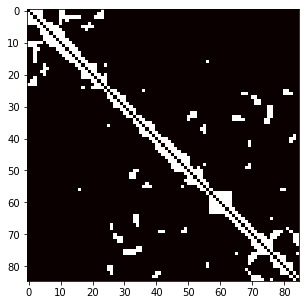

n_clusters:  6
sil:  0.23681329549759708
completeness:  0.34536129251774533
cr:  0.30294696004170024
nmi:  0.5045508823216297
###########################################################################################
dataset:  SMK_CAN


/home/marcos/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  # Remove the CWD from sys.path while we load stuff.


2
(187, 19993)
init loss:  15.612642149273173
best loss:  0.12943349549384947
n iter:  3


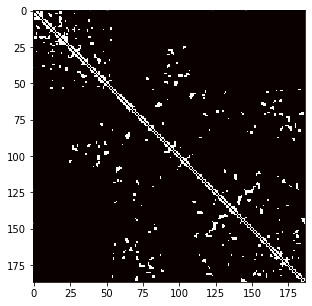

n_clusters:  7
sil:  0.22386422629098202
completeness:  0.09130647603115637
cr:  0.06295890602576118
nmi:  0.13340746234229478
CPU times: user 3min 29s, sys: 1.72 s, total: 3min 31s
Wall time: 1min 1s


In [130]:
%%time
datasets = [
    'GLI_85',
    'SMK_CAN',
#     'ELD_2011_2014'
]

for dataset_name in datasets:
    print('###########################################################################################')
    print('dataset: ', dataset_name)
    X, y = read_data(dataset_name)
    
    S, X_new = get_S(X)
    S = S.toarray()

    rcParams['figure.figsize'] = 5,5
    _ = plt.imshow(S, cmap='hot', interpolation='nearest')
    plt.show()
    
    clustering = get_clustering(S, X_new)
    
    evaluate(clustering, y)